# Using DataYoink's Pretrained Mask

This demo is inteded for users who have images of battery discharge curves from which they want to extract points. This can be accomplished easily by following the steps below in a jupyter notebook.

## Step 1: Import all requred packages

The import statements below may need to be modified based on where the requred .py files appear in your directory

In [1]:
from pyfiles_for_demos.coordconverter import datayoink_to_excel, get_axis_info
from pyfiles_for_demos.img_rescale import img_rescale
from pyfiles_for_demos.predict import predict_discharge_curve
from pyfiles_for_demos.predict import show_output_img_and_mask
from pyfiles_for_demos.pointclassifier import pointclassifier

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams.update({'font.size': 26})
%matplotlib inline
%matplotlib notebook

import ipywidgets as wdg
from ipywidgets import ToggleButtons

import pandas as pd
import numpy as np
import math

import xlsxwriter

## Step 2:  Load and resize Image

In [2]:
image_PNG = "Test_bw.png"
image_height = 400
image_width = 600
rescaled_img = img_rescale(image_PNG, image_height, image_width)

original image shape: (1493, 2583) is scaled to new image shape (400, 600)


## Step 3: Provide information about the image

###### Once you run the cell below, in the plot area, use your mouse to click on the following:
 
* 1.) Origin 
* 2.) X-axis max 
* 3.) Y-axis max
 
###### Notes:
* Be careful not to accidentally add extra clicks, in the case you do, re-run the cell
* Do your best to get your clicks as close to the corners as possible (edit figure size if it helps)
* Below the plot, there is a textbox named "event:" where, everytime you click on the image, a event is captured at the position where you clicked your mouse on the image, verify there is only 3 points selected (scroll down before you start clicking)
* Use the horizontal scroll bar below the image if part of your plot is cut-off

<IPython.core.display.Javascript object>


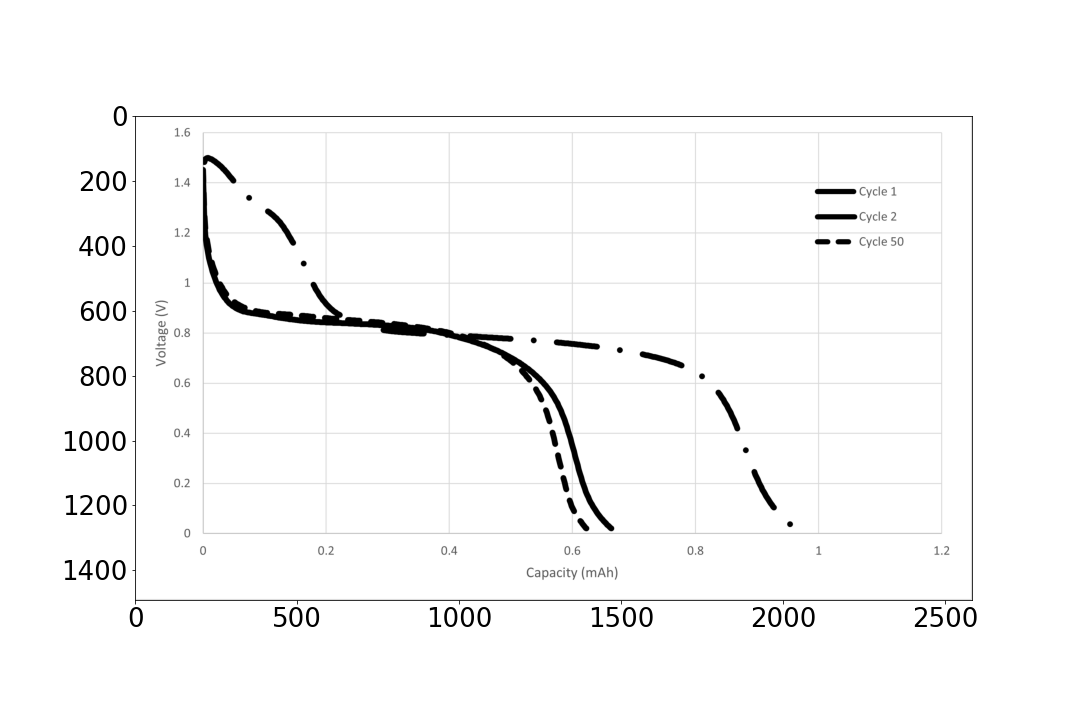

Textarea(value='', description='event:', placeholder='')

please select


In [3]:
# Initialize array of x and y pixels
x = []
y = []


# Load in a discharge curve
img = mpimg.imread("Test_bw.png")
fig = plt.figure(figsize=(15,10))
plt.imshow(img)

# Create and display textarea widget
txt = wdg.Textarea(
    value='',
    placeholder='',
    description='event:',
    disabled=False)
display(txt)
print("please select")

# Function to record mouse click events
def onclick(event):
    txt.value = str(event)  # Dynamically update the text box above
    # Create an hard reference to the callback not to be cleared by the garbage collector
    x.append(event.xdata)
    y.append(event.ydata)
ka = fig.canvas.mpl_connect('button_press_event', onclick)


In [4]:
xpixels = [round(num, -1) for num in x]
ypixels = [round(num, -1) for num in y]

In [5]:
print("the x coordinates are", xpixels)
print("the y coordinates are", ypixels)
userpoints = np.column_stack( (xpixels, ypixels) )

the x coordinates are [210.0, 210.0, 2490.0]
the y coordinates are [50.0, 1280.0, 1280.0]


In [6]:
pointclassifier(userpoints)

TypeError: float() argument must be a string or a number, not 'list'

In [7]:
origin, xpixelmax, ypixelmax = pointclassifier(userpoints)

TypeError: float() argument must be a string or a number, not 'list'

In [9]:
# for now I will manually update the values until the pointclassifier is up and running:
origin = [210.0, 1280.0]
xpixelmax = [2490.0, 1280.0]
ypixelmax = [210.0, 50.0]

###### User picks range of x and y on the axes

<IPython.core.display.Javascript object>


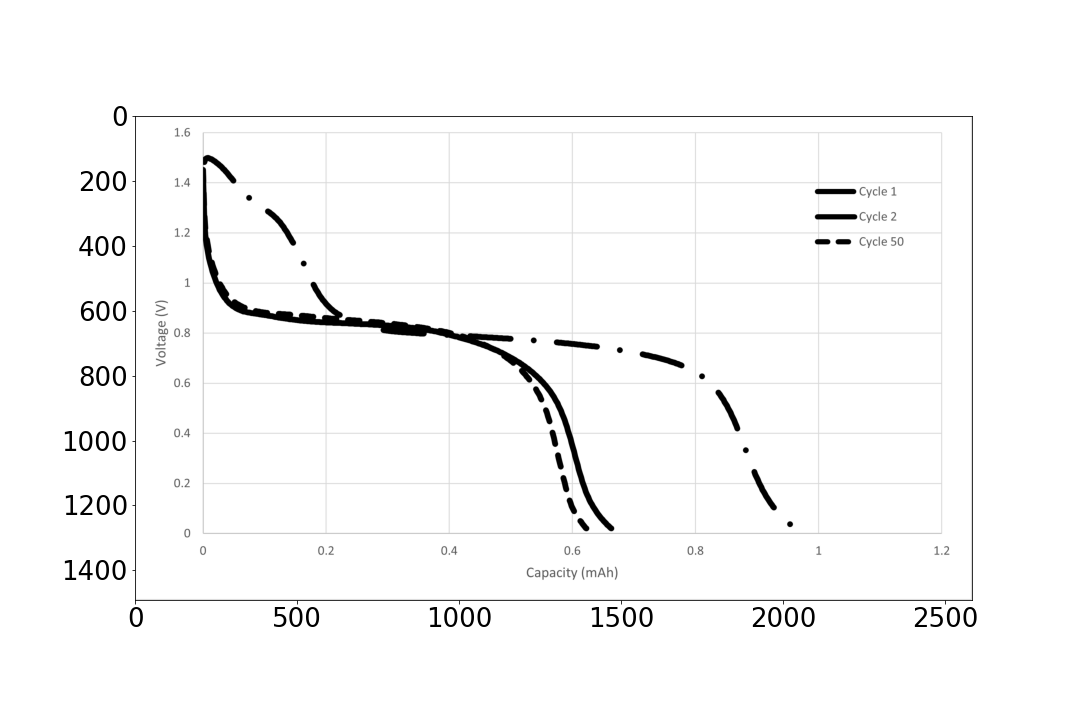

In [10]:
fig = plt.figure(figsize=(15,10))
plt.imshow(img)

In [12]:
max_points = int(input("Enter the max number of points desired for the x-axis:"))


assert type(max_points) == int, 'User input for the number of points should be an integer'
#assert type(max_points) > 5, 'User input for the number of points should be an integer'

Enter the max number of points desired for the x-axis:100


In [13]:
xcoordinatemin = float(input("Enter the x min value on the x-axis:"))
xcoordinatemax = float(input("Enter the x max value on the x-axis:"))


assert type(xcoordinatemin) == float, 'User input for the min X value on the x-axis is not the correct datatype'
assert type(xcoordinatemin) == float, 'User input for the max X value on the y-axis is not the correct datatype'
assert xcoordinatemin < xcoordinatemax, 'The min X value on the x-axis is greater than the max X value on the x-axis'

Enter the x min value on the x-axis:0
Enter the x max value on the x-axis:1.2


In [14]:
ycoordinatemin = float(input("Enter the y min value on the y-axis:"))
ycoordinatemax = float(input("Enter the y max value on the y-axis:"))

assert type(ycoordinatemin) == float, 'User input for the min Y value on the y-axis is not the correct datatype'
assert type(ycoordinatemin) == float, 'User input for the max Y value on the y-axis is not the correct datatype'
assert ycoordinatemin < ycoordinatemax, 'The min Y value on the y-axis is greater than the max Y value on the y-axis'

Enter the y min value on the y-axis:0
Enter the y max value on the y-axis:1.6


In [15]:
print("the range of the x-axis is", "(", xcoordinatemin, ",", xcoordinatemax, ")")
print("the range of the y-axis is", "(", ycoordinatemin, ",", ycoordinatemax, ")")

the range of the x-axis is ( 0.0 , 1.2 )
the range of the y-axis is ( 0.0 , 1.6 )


##### User selecting units of x and y axes

In [16]:
xunits = ToggleButtons(options=['Cycle Number', 'Voltage (V)'])
yunits = ToggleButtons(options=['mAh','mAh/g','mAh/cm^2', 'μAh/g', 'μAh/cm^2', 'Ah/(g * V)'])

In [17]:
xunits

ToggleButtons(options=('Cycle Number', 'Voltage (V)'), value='Cycle Number')

In [18]:
yunits

ToggleButtons(options=('mAh', 'mAh/g', 'mAh/cm^2', 'μAh/g', 'μAh/cm^2', 'Ah/(g * V)'), value='mAh')

In [19]:
units = [xunits,yunits]

In [20]:
print("You have selected your x-axis units as:", xunits.value, "\nYou have selected your y-axis units as:", yunits.value)

You have selected your x-axis units as: Cycle Number 
You have selected your y-axis units as: mAh


## Step 4: Run detectron2 using pretrained model

In [21]:
pretrained_pkl = "./output/BEST_config.pkl"
outputs = predict_discharge_curve(pretrained_pkl,rescaled_img)
show_output_img_and_mask("scaled_input_image/scaled_"+image_PNG, outputs)

FileNotFoundError: [Errno 2] No such file or directory: './output/BEST_config.pkl'

## Step 5. Use DataYoink to save coordinates to excel

The arguments for the following functions (except the filename, see below) do not need to be modified, they refer to variables already created by the above code. 

#### Filenames:
You may specify the base filename (in the datayoink_to_excel function) if desired. The resulting excel file will have the name ```filename_1```.

In [36]:
axis_info_dict = get_axis_info(xcoordinatemin, xcoordinatemax, xpixelmax,
                               ycoordinatemin, ycoordinatemax, ypixelmax,
                               origin, max_points, units)
datayoink_to_excel(outputs, axis_info_dict, filename='image')

IndexError: list index out of range

In [ ]:
type(xpixelmax)

In [ ]:
type(xpixelmax)